# Cargando Modelo

In [1]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras import models
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
image_size = 128

# Se carga el modelo 
model = load_model("modelo_3.h5")

# Se carga la direccion de la imagen
img_entrada = '20_cent__13'
img_path = img_entrada+'.jpg'

# Cargamos la imagen por medio de la librería de tensorflow
image_real = image.load_img(img_path)
image = image.load_img(img_path, target_size=(128,128), grayscale=True)

# Generamos el img_tensor como dato de entrada para el modelo
img_tensor = preprocessing.image.img_to_array(image)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = img_tensor/255

C:\Users\DELL\Anaconda3\envs\tf_gpu\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [3]:
img_tensor.shape

(1, 128, 128, 1)

In [4]:
print(model.predict(img_tensor))

[[1.21378935e-05 9.99987841e-01]]


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       5

In [6]:
# Se selecciona la ultima capa de convolución
conv_layer = model.get_layer("max_pooling2d_1")

# Y luego se produce el heatmap_model con:
# capa de entrada: model.inputs
# salida de la ultima capa de convolucion: conv_layer.output
# salida del modelo: model.ou tput
heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

In [7]:
# Se genera los gradientes para generar el mapa de calor
with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img_tensor)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [8]:
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat

print(heatmap.shape)

(1, 32, 32)


## Heatmap Mask

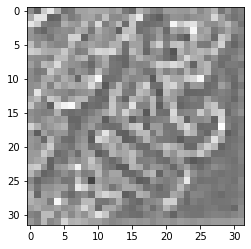

In [9]:
# Se genera la matriz del heatmap
import matplotlib.pyplot as plt
hm=np.squeeze(heatmap)
plt.imshow(cv2.cvtColor(hm, cv2.COLOR_BGR2RGB))
plt.show()

## Heatmap

In [10]:
img = cv2.imread(img_path)
heatmap = cv2.resize(hm, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [11]:
imagen_final = heatmap * 0.4 + image_real
cv2.imwrite(img_entrada+'_heatmap.jpg', np.array(imagen_final,np.int32))
cv2.imwrite(img_entrada+'_heatmap_solo.jpg', heatmap)

True

In [12]:
imagen_final = cv2.imread(img_entrada+'_heatmap.jpg')

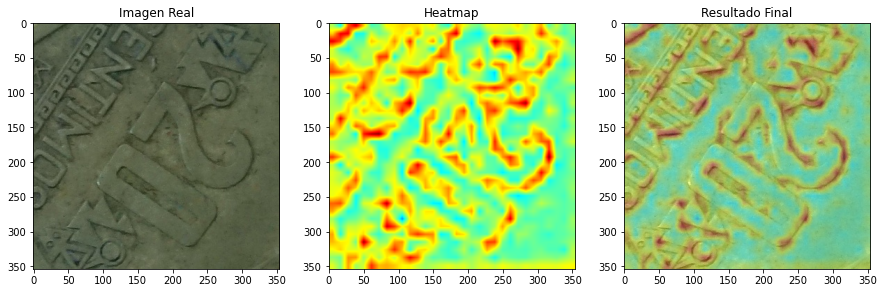

In [13]:
fig, axs = plt.subplots(1,3, figsize=(15,15))

axs[0].imshow(image_real)
axs[0].set_title('Imagen Real')

axs[1].imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
axs[1].set_title('Heatmap')

axs[2].imshow(cv2.cvtColor(imagen_final, cv2.COLOR_BGR2RGB))
axs[2].set_title('Resultado Final')

plt.show()

# Visualizing intermediate activations

In [14]:
layer_outputs = [layer.output for layer in model.layers[:6]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [15]:
activations = activation_model.predict(img_tensor)

In [16]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 128, 128, 128)


In [17]:
layer_names = []

for layer in model.layers[:6]:
    layer_names.append(layer.name)

In [18]:
layer_names

['conv2d',
 'conv2d_1',
 'max_pooling2d',
 'conv2d_2',
 'conv2d_3',
 'max_pooling2d_1']

In [19]:
images_per_row = 16

<ipython-input-20-598e5783eedc>:13: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


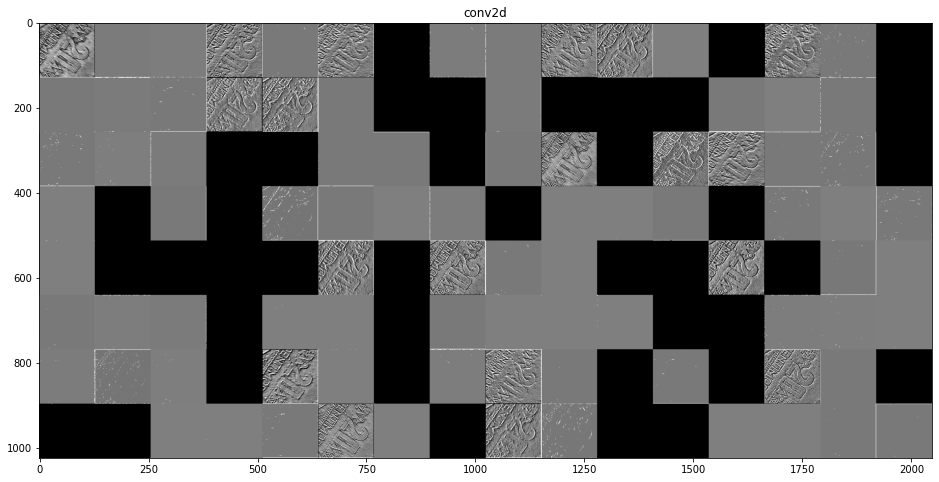

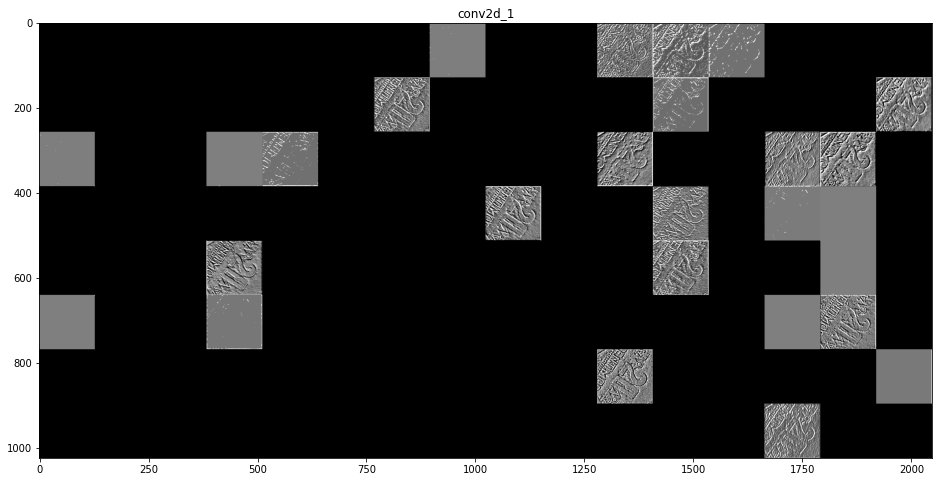

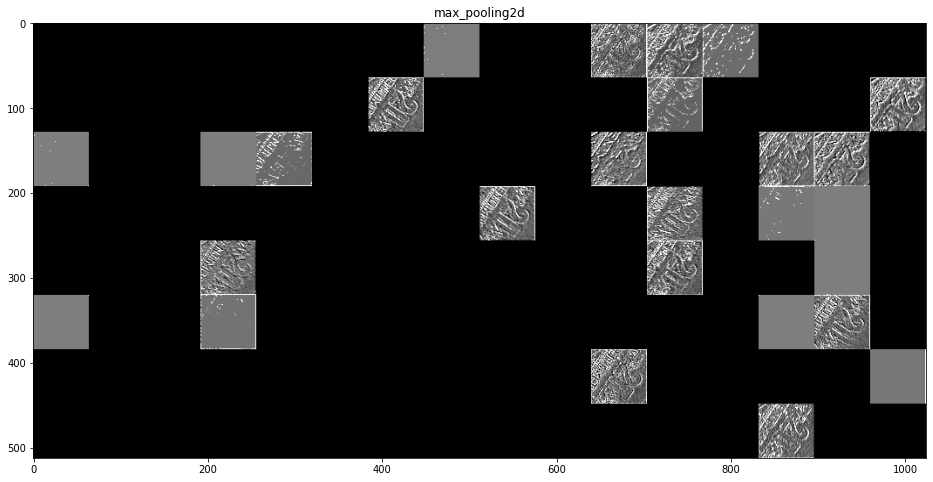

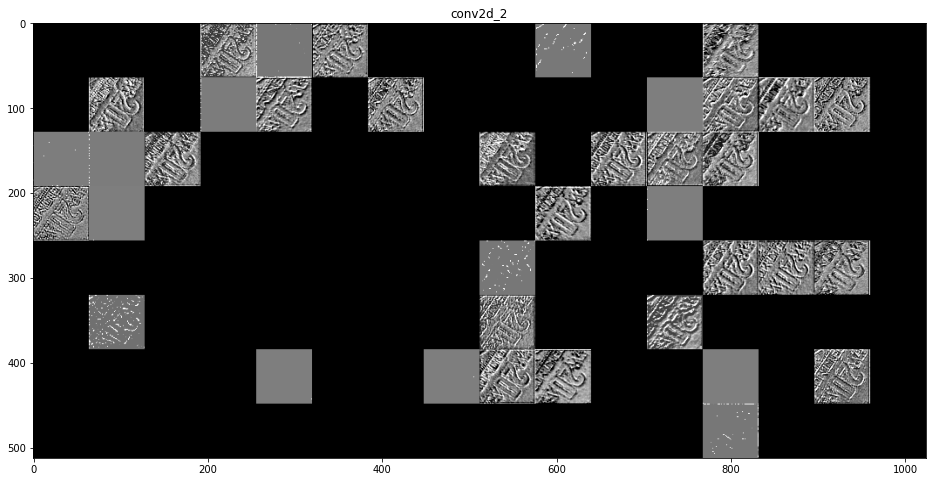

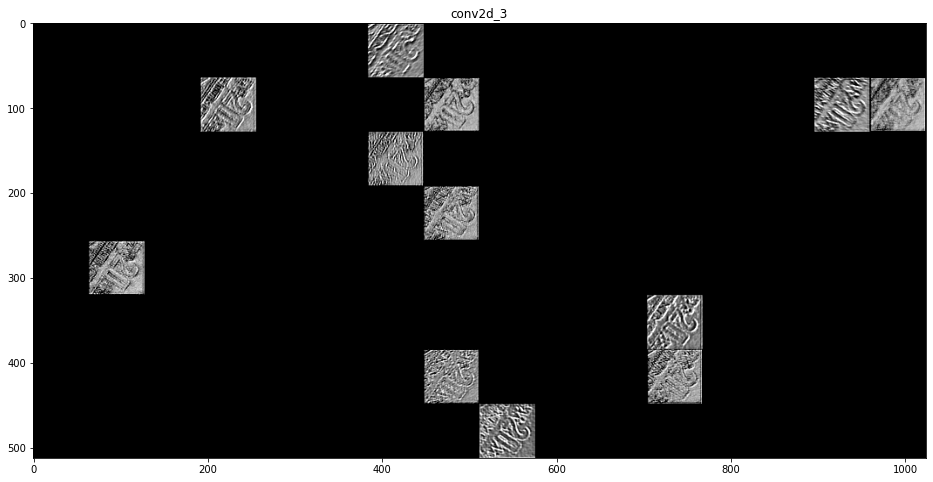

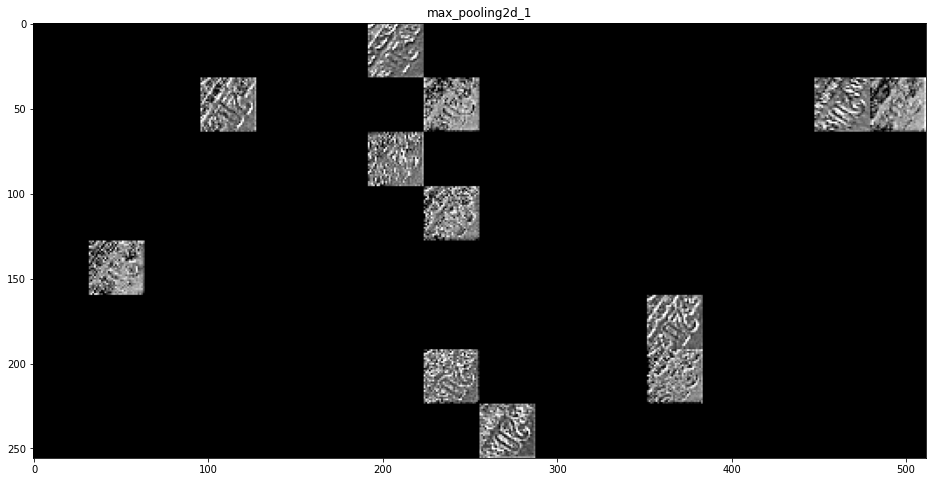

In [20]:
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                            :, :,
                                            col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
        
        scale = 1. / size

    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')
    plt.show()